In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.pipeline import Pipeline
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV, ElasticNetCV, SGDRegressor

from sklearn.model_selection import train_test_split

# Regularization and Gradient Descent

In this notebook we get some noisy sionusiodal data. We know the real function so it can easily be used for analysing the effectiveness of our fitting algorithms.

In [2]:
data = pd.read_csv("./data/X_Y_Sinusoid_Data.csv")
data.head()

X_real = np.linspace(0, 1.0, 100)
y_real = np.sin(2 * np.pi * X_real)

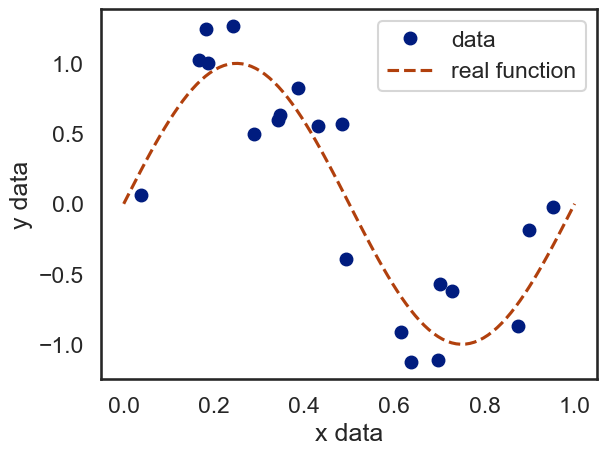

In [3]:
sns.set_style('white')
sns.set_context('talk')
sns.set_palette('dark')

# Plot of the noisy (sparse)
ax = data.set_index('x')['y'].plot(ls='', marker='o', label='data')
ax.plot(X_real, y_real, ls='--', marker='', label='real function')

ax.legend()
ax.set(xlabel='x data', ylabel='y data');

## Fitting with Polynomial features

A simple way of fitting is to simply use a polynomial of degree n. In this case we will use a polynomial of degree 20 to fit our datapoints. Of course this is much more than we need for the sinusoidal data above, but it is a good way of seeing the effectiveness of L1 and L2 regularisation.

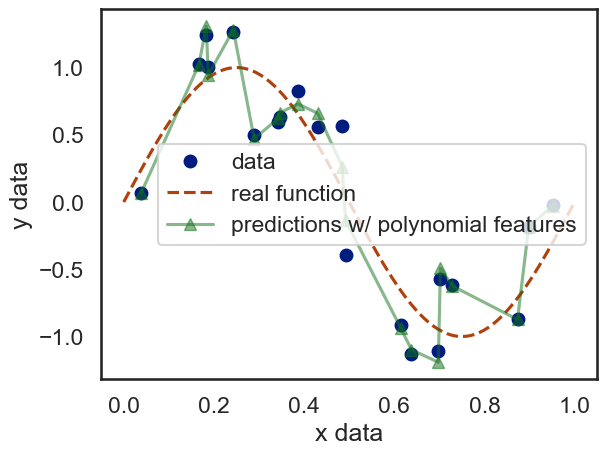

In [4]:
degree = 20
estimator = Pipeline(
    [
        ('poly', PolynomialFeatures(degree=degree)),
        ('regression', LinearRegression()),
    ]
)

X = data[['x']]
y = data['y']

estimator = estimator.fit(X, y)
y_pred = estimator.predict(X)

plt.plot(X,  y, marker='o', ls='', label='data', alpha=1)
plt.plot(X_real, y_real, ls='--', label='real function')
plt.plot(X, y_pred, marker='^', alpha=.5, label='predictions w/ polynomial features')
plt.legend()
ax = plt.gca()
ax.set(xlabel='x data', ylabel='y data');

So, as expected, way too many features leading to an overfit. The generalisation to unseen data would not work with this model. 

### Regularisation

With regularisation we add a penalty term to the function that evaluates model performance proportional to coefficient size. This makes it so that there is a cost to a coefficient becoming larger. This keeps coefficients smaal and reduces model variance.

Let's use the same code, as above, but use a different regression method instead: Ridge

p:\02_Poetry\Cache\virtualenvs\ibm-ml-sD2suF2h-py3.12\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.470e-01, tolerance: 1.223e-03
  model = cd_fast.enet_coordinate_descent(


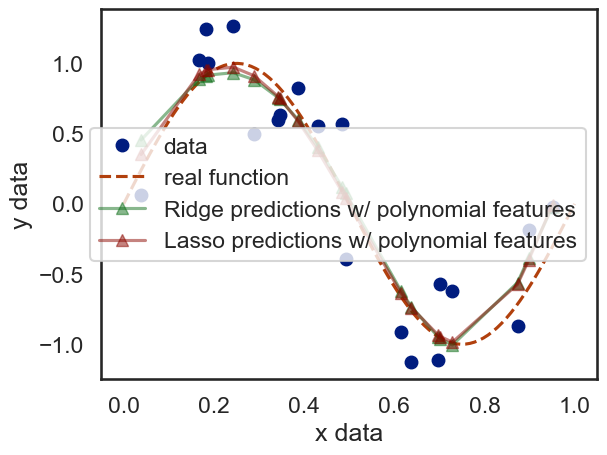

In [5]:
degree = 20
ridge_estimator = Pipeline(
    [
        ('poly', PolynomialFeatures(degree=degree)),
        ('regression', Ridge(alpha=0.001)),
    ]
)

lasso_estimator = Pipeline(
    [
        ('poly', PolynomialFeatures(degree=degree)),
        ('regression', Lasso(alpha=0.0001)),
    ]
)

X = data[['x']]
y = data['y']

ridge_estimator.fit(X, y)
y_pred_ridge = ridge_estimator.predict(X)
lasso_estimator.fit(X, y)
y_pred_lasso = lasso_estimator.predict(X)

plt.plot(X,  y, marker='o', ls='', label='data', alpha=1)
plt.plot(X_real, y_real, ls='--', label='real function')
plt.plot(X, y_pred_ridge, marker='^', alpha=.5, label='Ridge predictions w/ polynomial features')
plt.plot(X, y_pred_lasso, marker='^', alpha=.5, label='Lasso predictions w/ polynomial features')
plt.legend()
ax = plt.gca()
ax.set(xlabel='x data', ylabel='y data');

That looks much better. We can take a look at the coefficients themselves to find out what the regularisation procedure does in terms of coefficient size.

In [6]:
coefficients = pd.DataFrame()
coefficients['linear regression'] = estimator.named_steps['regression'].coef_.ravel()
coefficients['ridge regression'] = ridge_estimator.named_steps['regression'].coef_.ravel()
coefficients['lasso regression'] = lasso_estimator.named_steps['regression'].coef_.ravel()
coefficients = coefficients.map(abs)

coefficients.describe()

,linear regression,ridge regression,lasso regression
count,2.100000e+01,21.000000,21.000000
mean,2.426388e+11,2.169397,2.167284
std,2.707907e+11,2.900278,4.706731
min,1.866316e+06,0.000000,0.000000
25%,3.074914e+10,0.467578,0.000000
50%,1.257762e+11,1.017272,0.252181
75%,3.629261e+11,2.883507,1.641353
max,9.193628e+11,12.429635,20.176708


Which clearly shows that with regularisation the coefficients are kept to smaller values. So changing any of the parameters does not result in massive swings of the fit function.

## Regularised Housing Data

Let's now apply this to a more realistic situation with the Ames Housing Data. We'll import the data, encode the categorical features split into train/test sets, transform skewed features and scale for learning.

In [7]:
data = pd.read_csv("./data/Ames_Housing_Sales.csv")
# One-Hot encode
data = pd.get_dummies(data, drop_first=True)
# Log transform skewed columns
mask = data.dtypes == float
float_cols = data.columns[mask]
skew_vals = data[float_cols].skew().abs()
skew_limit = 0.75
skewed_cols = skew_vals[skew_vals > 0.75].index.drop('SalePrice')
data[skewed_cols] = np.log1p(data[skewed_cols])
# Split in train/test
X_train, X_test, y_train, y_test = train_test_split(
    data.drop('SalePrice', axis=1), 
    data['SalePrice'], 
    test_size=0.3, 
    random_state=42)

Then we can fit a basic linear regression model and evaluate to see how far this basic setup gets us.

In [8]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
linear_rmse = root_mean_squared_error(y_test, y_pred)
linear_rmse

42033.492152799554

Since the 'SalePrice' variable has a value of ~10, this means that the average error rate is a few percent. We can also see this by plotting the predictions vs the true results (a straight line would be perfect)

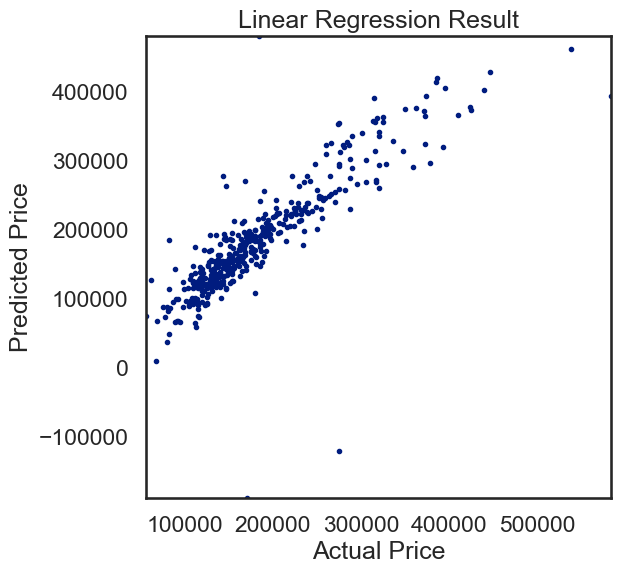

In [9]:
fig = plt.figure(figsize=(6, 6))
ax = plt.axes()

ax.plot(y_test, y_pred, marker='o', ls='', ms=3.0)
ax.set(
    xlabel='Actual Price',
    ylabel='Predicted Price',
    xlim=(y_test.min(), y_test.max()),
    ylim=(y_pred.min(), y_pred.max()),
    title="Linear Regression Result"
);

### Using RidgeCV

Combining Ridge regression with a cross validator can improve model performance even more. Let's see what happens when we apply this to our data.

In [10]:
alphas = [0.005, 0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 80]
ridgeCV = RidgeCV(alphas=alphas, 
                  cv=4).fit(X_train, y_train)
ridgeCV_rmse = root_mean_squared_error(y_test, ridgeCV.predict(X_test))

print(f"The best value of alpha = {ridgeCV.alpha_}, leading to an RMSE error of {ridgeCV_rmse:.4f}")

The best value of alpha = 10.0, leading to an RMSE error of 32022.0315


### Using LassoCV

Same goes for the L1 regularisation in Lasso

In [11]:
alphas2 = np.array([1e-5, 5e-5, 0.0001, 0.0005])

lassoCV = LassoCV(alphas=alphas2,
                  max_iter=int(5e4),
                  cv=3).fit(X_train, y_train)

lassoCV_rmse = root_mean_squared_error(y_test, lassoCV.predict(X_test))

print(f"The best value of alpha = {lassoCV.alpha_}, leading to an RMSE error of {lassoCV_rmse:.4f}")

p:\02_Poetry\Cache\virtualenvs\ibm-ml-sD2suF2h-py3.12\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.980e+10, tolerance: 3.871e+08
  model = cd_fast.enet_coordinate_descent_gram(
p:\02_Poetry\Cache\virtualenvs\ibm-ml-sD2suF2h-py3.12\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.981e+10, tolerance: 3.871e+08
  model = cd_fast.enet_coordinate_descent_gram(
p:\02_Poetry\Cache\virtualenvs\ibm-ml-sD2suF2h-py3.12\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check 

The best value of alpha = 0.0005, leading to an RMSE error of 46069.6386


p:\02_Poetry\Cache\virtualenvs\ibm-ml-sD2suF2h-py3.12\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.095e+11, tolerance: 6.103e+08
  model = cd_fast.enet_coordinate_descent(


### ElasticNet

A third option is to use ElasticNet, which combines L1 and L2 regularisation by using a tradeoff between the two./

In [12]:
l1_ratios = np.linspace(0.1, 0.9, 9)

elasticNetCV = ElasticNetCV(alphas=alphas2, 
                            l1_ratio=l1_ratios,
                            max_iter=int(1e4)).fit(X_train, y_train)
elasticNetCV_rmse = root_mean_squared_error(y_test, elasticNetCV.predict(X_test))

print(f"Alpha= {elasticNetCV.alpha_}, L1 ratio = {elasticNetCV.l1_ratio_}, rmse error = {elasticNetCV_rmse:.4f}")

p:\02_Poetry\Cache\virtualenvs\ibm-ml-sD2suF2h-py3.12\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.667e+11, tolerance: 4.874e+08
  model = cd_fast.enet_coordinate_descent_gram(
p:\02_Poetry\Cache\virtualenvs\ibm-ml-sD2suF2h-py3.12\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.370e+11, tolerance: 4.652e+08
  model = cd_fast.enet_coordinate_descent_gram(
p:\02_Poetry\Cache\virtualenvs\ibm-ml-sD2suF2h-py3.12\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check 

Alpha= 0.0005, L1 ratio = 0.1, rmse error = 36040.6586


p:\02_Poetry\Cache\virtualenvs\ibm-ml-sD2suF2h-py3.12\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.482e+11, tolerance: 4.884e+08
  model = cd_fast.enet_coordinate_descent_gram(


We can easily compare the perfomance of the models by tabulating the RMSE values, where we can see that in this case Ridge performs best.

In [13]:
rmse_vals = [linear_rmse, ridgeCV_rmse, lassoCV_rmse, elasticNetCV_rmse]

labels = ['Linear', 'Ridge', 'Lasso', 'ElasticNet']

rmse_df = pd.Series(rmse_vals, index=labels).to_frame()
rmse_df.rename(columns={0: 'RMSE'}, inplace=1)
rmse_df

,RMSE
Linear,42033.492153
Ridge,32022.031470
Lasso,46069.638570
ElasticNet,36040.658585


A plot of the predictions versus the real values can also give a lot of insight. In this case we can see that they perform very similarly.

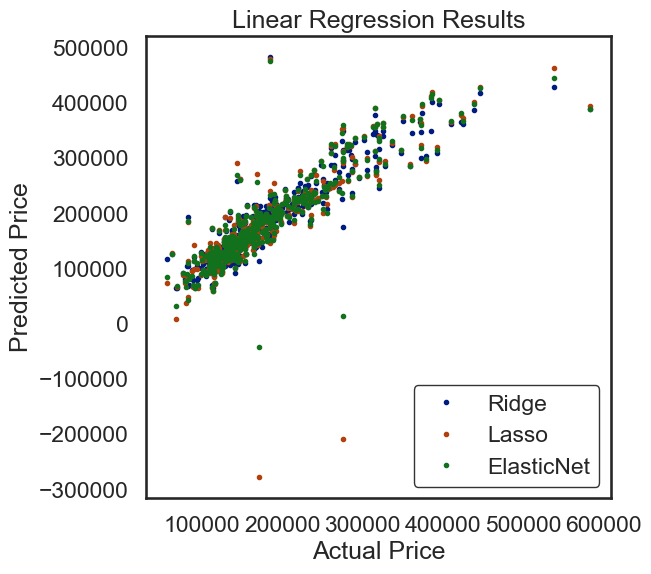

In [14]:
f = plt.figure(figsize=(6,6))
ax = plt.axes()

labels = ['Ridge', 'Lasso', 'ElasticNet']

models = [ridgeCV, lassoCV, elasticNetCV]

for mod, lab in zip(models, labels):
    ax.plot(y_test, mod.predict(X_test), 
             marker='o', ls='', ms=3.0, label=lab)

leg = plt.legend(frameon=True)
leg.get_frame().set_edgecolor('black')
leg.get_frame().set_linewidth(1.0)

ax.set(xlabel='Actual Price', 
       ylabel='Predicted Price', 
       title='Linear Regression Results');

## Gradient Descent

Another method for regression is Stochastic Gradient Descent (SGD). The SGD algorithm is *very* sensitive to scaling of the features (this is also used in Deep Learning and already informs why scaling is so important there).

In SGD, an iterative approach is taken instead of the closed form least-squares method used in linear regression. This has some advantages, like better handling of large datasets (scalability) and choice of different objective functions. A disadvantage is that the algorithm can converge to a local minimum, instead of the global, which Linear Regression is guaranteed to do. 

Another disadvantage is that it is really easy to make SGD diverge, errors can accumulate and feature scale and learning rate can give significant trouble during training. On the other hand, too low learning rates may make the model converge extremely slowly, or not at all. Therefore it is important to scale the data and check for an appropriate learning rate (for example with cross validation)

Below we fit an SGD model, using the parameters for regularisation we determined above with cross validation.

In [15]:
model_parameters_dict = {
    'Linear': {'penalty': None},
    'Lasso': {'penalty': 'l1',
           'alpha': lassoCV.alpha_},
    'Ridge': {'penalty': 'l2',
           'alpha': ridgeCV.alpha_},
    'ElasticNet': {'penalty': 'elasticnet', 
                   'alpha': elasticNetCV.alpha_,
                   'l1_ratio': elasticNetCV.l1_ratio_}
}

new_rmses = {}
for modellabel, parameters in model_parameters_dict.items():
    # following notation passes the dict items as arguments
    SGD = SGDRegressor(eta0=1e-7, max_iter=1000, random_state=42, **parameters)
    SGD.fit(X_train, y_train)
    new_rmses[modellabel] = root_mean_squared_error(y_test, SGD.predict(X_test))

rmse_df['RMSE-SGD-learningrate'] = pd.Series(new_rmses)
rmse_df

,RMSE,RMSE-SGD-learningrate
Linear,42033.492153,74727.748692
Ridge,32022.031470,74730.737223
Lasso,46069.638570,74727.748696
ElasticNet,36040.658585,74727.748827


In this case, SGD performs worse. Which may be the result of not scaling the input data. Let's apply simple MinMax scaling and see if that helps.

In [16]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

new_rmses = {}
for modellabel, parameters in model_parameters_dict.items():
    # following notation passes the dict items as arguments
    SGD = SGDRegressor(max_iter=1000, random_state=42, **parameters)
    SGD.fit(X_train_scaled, y_train)
    new_rmses[modellabel] = root_mean_squared_error(y_test, SGD.predict(X_test_scaled))

rmse_df['RMSE-SGD-scaled'] = pd.Series(new_rmses)
rmse_df

,RMSE,RMSE-SGD-learningrate,RMSE-SGD-scaled
Linear,42033.492153,74727.748692,32581.179282
Ridge,32022.031470,74730.737223,70971.814436
Lasso,46069.638570,74727.748696,32581.171982
ElasticNet,36040.658585,74727.748827,32549.332604


## Scaling Both Features AND Target

The issue in the previous attempt is that we scaled the features but not the target variable. SGD is sensitive to the scale of both X and y. When features are in [0,1] but y is in thousands, the algorithm struggles. Let's scale both:


In [17]:
# Scale both X and y using StandardScaler (better for SGD than MinMaxScaler)
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled_std = scaler_X.fit_transform(X_train)
X_test_scaled_std = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).ravel()

new_rmses = {}
for modellabel, parameters in model_parameters_dict.items():
    # following notation passes the dict items as arguments
    SGD = SGDRegressor(max_iter=1000, random_state=42, **parameters)
    SGD.fit(X_train_scaled_std, y_train_scaled)
    # Predictions on scaled y, need to inverse transform to compare RMSE
    y_pred_scaled = SGD.predict(X_test_scaled_std)
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()
    new_rmses[modellabel] = root_mean_squared_error(y_test, y_pred)

rmse_df['RMSE-SGD-both-scaled'] = pd.Series(new_rmses)
rmse_df


,RMSE,RMSE-SGD-learningrate,RMSE-SGD-scaled,RMSE-SGD-both-scaled
Linear,42033.492153,74727.748692,32581.179282,48944.015143
Ridge,32022.031470,74730.737223,70971.814436,42513.940690
Lasso,46069.638570,74727.748696,32581.171982,44102.496733
ElasticNet,36040.658585,74727.748827,32549.332604,48356.111883
